<a href="https://colab.research.google.com/github/ykato27/Auto-Encorder/blob/main/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Denoising Autoencoder

In [1]:
!pip install pycodestyle flake8 pycodestyle_magic

     |████████████████████████████████| 41 kB 331 kB/s 
     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 


In [2]:
%load_ext pycodestyle_magic

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28,28,1))
print(x_train.shape)
print(x_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


# ノイズを加える。

##  >>> # 平均:50, 標準偏差:10 の正規分布に従う乱数を 10 件出力する例

np.random.normal(50, 10, 10)

## 　numpy.random.normal(loc=0.0, scale=1.0, size=None)

loc:平均
scale:標準偏差

## np.clip (配列、min, max)

配列の要素を範囲内に収めるように修正してくれる。
n.clip(配列、0., 1.)で0以下を0に1を超えるものを1に修正する効果がある。

In [4]:
noise_factor = 0.5
# 平均0、標準偏差1の正規分布

# (60000,1,28,28)の平均0、標準偏差1のデータにnoise_factorを足したものをx_trainに足してノイズを加える。

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0., scale=1., size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0., scale=1., size=x_test.shape)
print(x_train_noisy.shape)
print(x_test_noisy.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


# 画像を出力することにより、ノイズが加わっているかどうかチェック
# ノイズを加えた画像を可視化

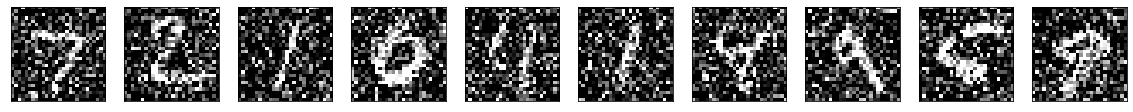

In [5]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0     

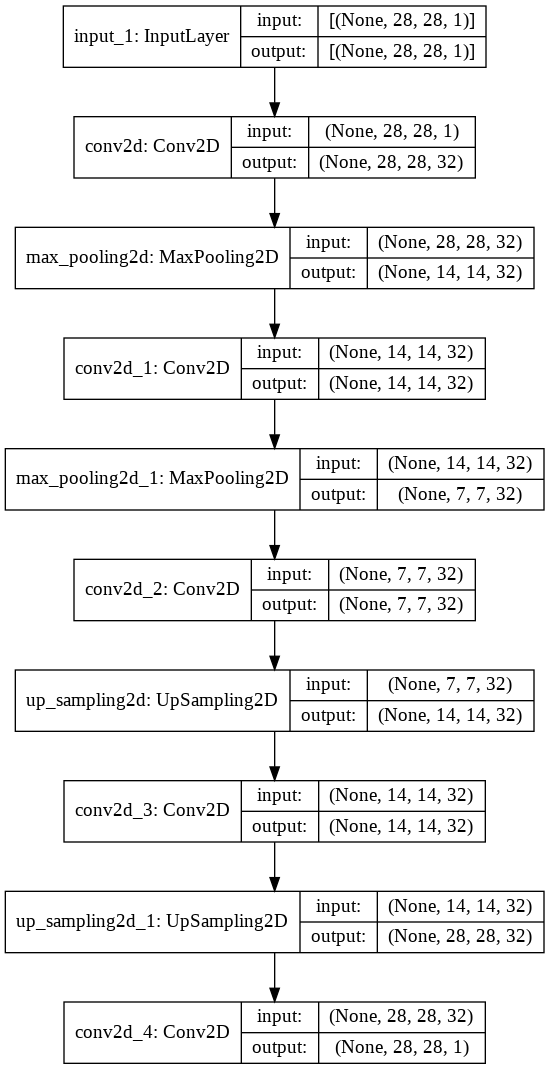

In [8]:
from tensorflow.python.keras.utils.vis_utils import plot_model

#モデルの描画
plot_model(autoencoder, to_file="architecture_dae.png", show_shapes=True)

# ノイズを加えた画像を入力、ノイズのないオリジナルの画像をラベルとして学習させる。

In [9]:
import keras
log_filepath = "./logs/"
tb_cb = keras.callbacks.TensorBoard(log_dir=log_filepath, histogram_freq=1, write_graph=True, write_images=True)

autoencoder.fit(x_train, x_train,
                       epochs=50,
                       batch_size=128,
                       shuffle=True,
                       callbacks=[tb_cb],
                       validation_data=(x_test, x_test)
                       )

Epoch 1/50
469/469 [==============================] - 162s 314ms/step - loss: 0.1888 - val_loss: 0.0755
Epoch 2/50
469/469 [==============================] - 145s 309ms/step - loss: 0.0752 - val_loss: 0.0718
Epoch 3/50
469/469 [==============================] - 145s 310ms/step - loss: 0.0717 - val_loss: 0.0697
Epoch 4/50
469/469 [==============================] - 145s 310ms/step - loss: 0.0702 - val_loss: 0.0688
Epoch 5/50
469/469 [==============================] - 145s 309ms/step - loss: 0.0691 - val_loss: 0.0680
Epoch 6/50
469/469 [==============================] - 146s 312ms/step - loss: 0.0684 - val_loss: 0.0674
Epoch 7/50
469/469 [==============================] - 144s 308ms/step - loss: 0.0678 - val_loss: 0.0673
Epoch 8/50
469/469 [==============================] - 144s 307ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 9/50
469/469 [==============================] - 146s 310ms/step - loss: 0.0671 - val_loss: 0.0662
Epoch 10/50
469/469 [==============================] - 146s 311m

In [10]:
import matplotlib.pyplot as plt

# テスト画像を変換
decoded_imgs = autoencoder.predict(x_test)
print(decoded_imgs.shape)

(10000, 28, 28, 1)


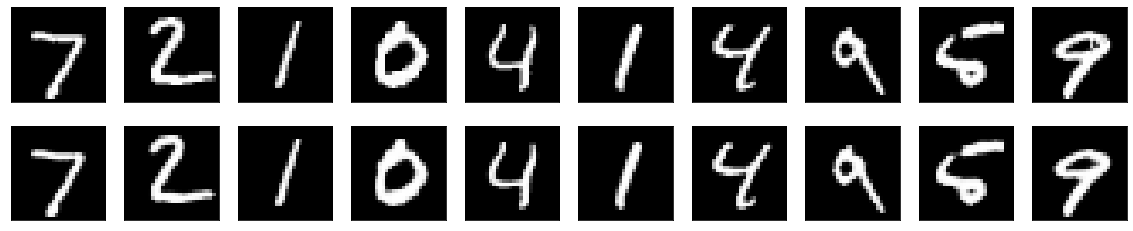

In [11]:
# 何個表示するか
# plt.subplot(行数, 列数, 何番目のプロットか)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)  #軸の値の表示を無効化
    ax.get_yaxis().set_visible(False)  #軸の値の表示を無効化
plt.show()